In [1]:
#@title Start up
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%pip install ffmpeg

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import cv2
import math
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from IPython.display import HTML

from collections import defaultdict
from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, CirclePolygon, Ellipse
from shapely.geometry import Polygon

from matplotlib import rc
rc('animation', html='jshtml')

rootdir = "/content/drive/MyDrive/XAMI-MIMIC"
%matplotlib inline


# show all rows from dataframe
pd.set_option('display.max_rows', 100)
# show all columns from dataframe
pd.set_option('display.max_columns', 100)

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=52464c4d5ac635b0dd574a88c4f36e70a8b4f60b4b51e1ab3a6b97d1caf6fb51
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [ ]:
#@title Start Reflacx Variable
%%script echo skipping
import os

reflacx = {}

with os.scandir(rootdir) as dirsList:
    for dirEntry in dirsList:
        if dirEntry.is_dir():
            with os.scandir(dirEntry.path) as dirsList1:
                if any('REFLACX' in entry.name for entry in dirsList1):
                    reflacx[dirEntry.name] = []
                    metadata_path = os.path.join(dirEntry.path, 'REFLACX/metadata.csv')
                    metadata = pd.read_csv(metadata_path)
                    jpg_name = metadata['dicom_id'][0]
                    x_size = metadata['image_size_x'][0]
                    y_size = metadata['image_size_y'][0]
                    with os.scandir(os.path.join(dirEntry.path, 'CXR-JPG')) as jpgFilesList:
                        for jpgFilesEntry in jpgFilesList:
                            if jpgFilesEntry.name.startswith('s'):
                                with os.scandir(jpgFilesEntry.path) as files3:
                                    for filenameEntry in files3:
                                        if filenameEntry.name.startswith(jpg_name):
                                            reflacx[dirEntry.name].append([jpgFilesEntry.name, filenameEntry.name, x_size, y_size])

                    dirsList4 = os.listdir(os.path.join(dirEntry.path, 'REFLACX'))
                    reflacx[dirEntry.name].append(dirsList4[1:])

print(reflacx)


skipping


In [4]:
#@title Init Variables
import pickle
SCREEN_RES = [3180, 2160]

FONT_SIZE = 4

to_save_images = "/content/drive/MyDrive/REFLACX-plots"
ignore_labels = ['xmin', 'ymin', 'xmax', 'ymax', 'certainty']

ellipses_labels = ['Acute fracture', 'Other', 'Pleural abnormality', 'Atelectasis', 'Pulmonary edema', 'Consolidation', 'Enlarged cardiac silhouette', 'Pneumothorax', 'Enlarged hilum', 'Interstitial lung disease', 'Groundglass opacity', 'Abnormal mediastinal contour', 'Lung nodule or mass', 'Pleural effusion', 'Fracture', 'Pleural thickening', 'High lung volume / emphysema', 'Hiatal hernia', 'Airway wall thickening', 'Emphysema', 'Nodule', 'Wide mediastinum', 'Fibrosis', 'Mass', 'Nothing']
# calculator for scalene triangle: https://www.omnicalculator.com/math/scalene-triangle
# visual angle and distance to size: https://elvers.us/perception/visualAngle/#:~:text=The%20visual%20angle%20of%20an,lead%20to%20larger%20visual%20angles.


# 71cm to top of screen, 68cm to the bottom, angle of 2º distance in screen 6.71cm
# screen has 64ppcm => 429.44 pixels of diameter => ~215 pixels of radius
#RADIUS = 215

# using the visual angle calculator
RADIUS = 90.5472  # assuming distance to the screen of 64.84 using the scalene formula
#RADIUS = 94.96    # assuming distance to the screen of 68 using the mean of top and bottom

with open("/content/drive/MyDrive/Colab-Variables/reflacx_dirs.pkl",'rb') as file:
  reflacx = pickle.load(file)

In [33]:
#@title Cluster Function
def clusterFunction(space_points, timestamped_points, elipses):
  space_points = np.array(space_points)
  nn = NearestNeighbors(n_neighbors=10, radius = RADIUS, algorithm='kd_tree')
  nn.fit(space_points)

  clusters = [] # contains any potential cluster

  # points in space to check for clusters
  points_x, points_y = np.meshgrid(np.arange(RADIUS, 2544, RADIUS/2), np.arange(RADIUS, 3056, RADIUS/2))
  points = np.column_stack((points_x.ravel(), points_y.ravel()))
  clusters = nn.radius_neighbors(points, RADIUS)

  PFCs = [] # potential Foveal Clusters
  PPCs = [] # potential Peripheral Clusters

  for cluster in clusters[1]:
    if len(cluster) > 3:
      PFCs.append(cluster)
    elif len(cluster) == 2:
      PPCs.append(cluster)


  # check against the timestamps to see if they are indeed sequential
  def is_sequential(cluster):
    lst = []
    for index in cluster:
      lst.append(timestamped_points[index])
    for i in range(1, len(lst)):
      if lst[i] != lst[i-1] + 1:
        return False
    return True

  # look for sequences with consecutive timestamps in the PFCs
  def checkSequence(lst):
    sequences = []
    lst = sorted(lst)
    seq_start = lst[0]

    for i in range(1, len(lst)):
        if lst[i] == lst[i-1] + 1:
            continue
        seq_end = lst[i-1]
        if seq_end > seq_start:
            sequences.append(list(range(seq_start, seq_end+1)))
        seq_start = lst[i]

    seq_end = lst[-1]
    if seq_end > seq_start:
        sequences.append(list(range(seq_start, seq_end+1)))

    if sequences:
      return sequences

  #------------------------------------
  # select only PCs that have two consecutive timestamps
  PCs = []
  for pc in PPCs:
    pc = sorted(pc)
    if len(pc) == 2:
      if pc[0]+1 == pc[1]:
        if pc not in PCs:
          if is_sequential(pc):
            PCs.append(pc)

  #------------------------------------
  FCs = []
  for fc in PFCs:
    aux = (checkSequence(fc))
    if aux is not None:
      for tmp in aux:
        if is_sequential(tmp):
          if len(tmp) == 2 and tmp not in PCs:
              PCs.append(tmp)
          elif len(tmp) > 2 and tmp not in FCs:
              FCs.append(tmp)

  #------------------------------------
  new_FCs = []
  FCs = sorted(FCs,key=len)
  fcs_by_len = {}

  def sequenceInList(cluster, lst_clusters):
    for clusters in lst_clusters:
      for cluster_test in clusters:
        if set(cluster).issubset(cluster_test):
          return True
    return False

  if len(FCs) > 0:
    for fc in FCs:
      lenght = len(fc)
      if lenght not in fcs_by_len:
        fcs_by_len[lenght] = [fc]
      else:
        fcs_by_len[lenght].append(fc)

    lenghts = list(fcs_by_len.keys())
    blackListed = []

    for i in range(len(lenghts) - 1):
      black_listed = lenghts[:i+1]
      resultset = [value for key, value in fcs_by_len.items() if key not in black_listed]
      for cluster in fcs_by_len[lenghts[i]]:
          if not sequenceInList(cluster, resultset):
              new_FCs.append(cluster)

    new_FCs += fcs_by_len[lenghts[-1]]
    FCs = new_FCs
  #------------------------------------
  # remove any PC if the sequence is already included in the FCs
  new_PCs = []
  FC_sets = [set(fc) for fc in FCs]
  for pc in PCs:
    if any(set(pc).issubset(fc) for fc in FC_sets):
      continue
    new_PCs.append(pc)
  PCs = new_PCs

  #------------------------------------
  def getCentroid(cluster):
    tmp = []
    for index in cluster:
      tmp.append(space_points[index])
    tmp = np.array(tmp)

    length = tmp.shape[0]
    sum_x = np.sum(tmp[:, 0])
    sum_y = np.sum(tmp[:, 1])
    return sum_x/length, sum_y/length

  def getTruePCs(centroid_x, centroid_y, eli_x_min, eli_y_min, eli_x_max, eli_y_max):
    if eli_x_min < centroid_x < eli_x_max and eli_y_min < centroid_y < eli_y_max :
      return True
    else:
      return False
  #------------------------------------
  FC_centroids = []
  for cluster in FCs:
    FC_centroids.append(getCentroid(cluster))

  # use getTruePCs when testing Sunettas approach
  PC_centroids = []
  for cluster in PCs:
    x,y = getCentroid(cluster)
    PC_centroids.append((x,y))
    """
    for (xmin,ymin,xmax,ymax) in zip (elipses['xmin'].values, elipses['ymin'].values, elipses['xmax'].values, elipses['ymax'].values):
      if getTruePCs(x,y,xmin,ymin,xmax,ymax):
        PC_centroids.append((x,y))
        break
    #"""
  return FC_centroids, PC_centroids

In [31]:
#@title Draw Plots
def elipsedraw(a):
    x = (a[0]+a[2])/2
    y = (a[1]+a[3])/2
    w = a[2]-a[0]
    h = a[3]-a[1]
    return Ellipse(xy=(x, y), width=w, height=h, edgecolor='r', fc='None', lw=0.25)

def makePlot(key, sname, pname, size_x, size_y, image_path, fixations_path, elipses_path, transcriptions_path):
  try:
    fixations = pd.read_csv(fixations_path)
    elipses = pd.read_csv(elipses_path)
    transcriptions = pd.read_csv(transcriptions_path)
    img = plt.imread(image_path)
  except FileNotFoundError:
    return 0

  sample = fixations
  sample2 = elipses
  transc_start = transcriptions["timestamp_start_word"][0]

  IMG_W = size_x
  IMG_H = size_y

  # initial fixations
  init = fixations[ (fixations.xmin_shown_from_image == 0) & (fixations.ymin_shown_from_image == 0)].head(1)

  # get initial screeen coordinates
  screen_xmin = init.xmin_in_screen_coordinates.values[0]
  screen_xmax = init.xmax_in_screen_coordinates.values[0]
  screen_ymin = init.ymin_in_screen_coordinates.values[0]
  screen_ymax = init.ymax_in_screen_coordinates.values[0]

  # we can now determine what the screen's dimensions are in the image space
  xmax_image = int(np.round((SCREEN_RES[0]*(IMG_W))/(SCREEN_RES[0]-(screen_xmin)),0))
  left_menu_Xsize_img = int(np.round((screen_xmin*(IMG_W))/(SCREEN_RES[0]-(screen_xmin)),0))
  # in the video demo provided with the paper, the right menu has the same size as the left menu
  # however, in terms of data, the full right menu is cropped
  # we will mimic the video demo and assume
  right_menu_Xsize_img = left_menu_Xsize_img


  plt.rcParams["figure.dpi"] = 300
  plt.rcParams["figure.autolayout"] = True
  # working in the image space
  fig = plt.figure()
  ax = plt.axes()

  ax.set_ylim([0,IMG_H])
  ax.set_xlim([0, IMG_W])

  # (0,0) on top left corner
  ax.invert_yaxis()

  # IMAGE DISPLAY AREA
  ax.imshow(img, cmap="gray")

  x_left = [-1*(left_menu_Xsize_img-1), -1]
  x_right = [IMG_W+1, IMG_W+1+right_menu_Xsize_img]

  # fixations (in image coordinates)
  sample = fixations
  sample2 = elipses

  # x an y coordinates of point in the image
  space_points = []
  # index correspondes to space_points and can be used to retrive the timestamp of any space_point by index
  timestamped_points = []
  CHECK_TIMESTAMP = False
  i = 0
  for (x_img, y_img, xmin_screen, xmax_screen, ymin_screen, ymax_screen, stamp) in zip( sample["x_position"].values, sample["y_position"].values,
                                                                                  sample["xmin_in_screen_coordinates"].values, sample["xmax_in_screen_coordinates"].values,
                                                                                  sample["ymin_in_screen_coordinates"].values, sample["ymax_in_screen_coordinates"].values,
                                                                                  sample["timestamp_start_fixation"].values):

      if x_left[0] < x_img < x_left[1] or x_right[0] < x_img < x_right[0]:
        pass
      else:
        if CHECK_TIMESTAMP:
          if stamp >= transc_start:
            ax.scatter(x_img, y_img, s=0.25, c="#F39C12", facecolors='#2E86C1', edgecolors="#E67E22")
            ax.annotate(i,(x_img,y_img),fontsize = 2.5)
            space_points.append([x_img,y_img])
            timestamped_points.append(i)

        else:
          ax.scatter(x_img, y_img, s=0.25, c="#F39C12", facecolors='#2E86C1', edgecolors="#E67E22")
          ax.annotate(i,(x_img,y_img),fontsize = 2.5)
          space_points.append([x_img,y_img])
          timestamped_points.append(i)

        i = i+1

  for (xmin,ymin,xmax,ymax) in zip (elipses['xmin'].values, elipses['ymin'].values, elipses['xmax'].values, elipses['ymax'].values):
    ax.add_patch(elipsedraw([xmin,ymin,xmax,ymax]))

  FC_centroids, PC_centroids = clusterFunction(space_points, timestamped_points, elipses)

  # add circles for each FC
  for centroid in FC_centroids:
    circle = plt.Circle((centroid[0], centroid[1]), RADIUS, color='b', fill=False, lw=0.25)
    ax.add_patch(circle)
  # add circles for each PC
  for centroid in PC_centroids:
    circle = plt.Circle((centroid[0], centroid[1]), RADIUS, color='g', fill=False, lw=0.25)
    ax.add_patch(circle)

  plt.xticks([])
  plt.yticks([])
  plt.show()
  #plt.savefig(f"{to_save_images}/{folder_name}/{key}_{sname}_{pname}")
  plt.close()


In [ ]:
#@title Compute Statistics
def computeStatistics(key, sname, pname, size_x, size_y, image_path, fixations_path, elipses_path, transcriptions_path):
  try:
    fixations = pd.read_csv(fixations_path)
    elipses = pd.read_csv(elipses_path)
    transcriptions = pd.read_csv(transcriptions_path)
    img = plt.imread(image_path)
  except FileNotFoundError:
    return 0

  sample = fixations
  sample2 = elipses
  transc_start = transcriptions["timestamp_start_word"][0]

  IMG_W = size_x
  IMG_H = size_y

  # initial fixations
  init = fixations[ (fixations.xmin_shown_from_image == 0) & (fixations.ymin_shown_from_image == 0)].head(1)

  # get initial screeen coordinates
  screen_xmin = init.xmin_in_screen_coordinates.values[0]
  screen_xmax = init.xmax_in_screen_coordinates.values[0]
  screen_ymin = init.ymin_in_screen_coordinates.values[0]
  screen_ymax = init.ymax_in_screen_coordinates.values[0]

  # we can now determine what the screen's dimensions are in the image space
  xmax_image = int(np.round((SCREEN_RES[0]*(IMG_W))/(SCREEN_RES[0]-(screen_xmin)),0))
  left_menu_Xsize_img = int(np.round((screen_xmin*(IMG_W))/(SCREEN_RES[0]-(screen_xmin)),0))
  # in the video demo provided with the paper, the right menu has the same size as the left menu
  # however, in terms of data, the full right menu is cropped
  # we will mimic the video demo and assume the right menu = the left menu
  right_menu_Xsize_img = left_menu_Xsize_img

  x_left = [-1*(left_menu_Xsize_img-1), -1]
  x_right = [IMG_W+1, IMG_W+1+right_menu_Xsize_img]

  # x an y coordinates of point in the image
  space_points = []
  ms_space_points = []
  silence_space_points = []
  # index correspondes to space_points and can be used to retrive the timestamp of any space_point by index
  timestamped_points = []
  ms_timestamped_points = []
  silence_timestamped_points = []

  i = 0
  for (x_img, y_img, xmin_screen, xmax_screen, ymin_screen, ymax_screen, stamp) in zip( sample["x_position"].values, sample["y_position"].values,
                                                                                  sample["xmin_in_screen_coordinates"].values, sample["xmax_in_screen_coordinates"].values,
                                                                                  sample["ymin_in_screen_coordinates"].values, sample["ymax_in_screen_coordinates"].values,
                                                                                  sample["timestamp_start_fixation"].values):

      if x_left[0] < x_img < x_left[1] or x_right[0] < x_img < x_right[0]:
        pass
      else:
        if stamp >= transc_start:
          ms_space_points.append([x_img,y_img])
          ms_timestamped_points.append(i)
        else:
          silence_space_points.append([x_img,y_img])
          silence_timestamped_points.append(i)
        space_points.append([x_img,y_img])
        timestamped_points.append(i)

      i = i+1

  elipses_stats = {}
  elipse_labels = list(elipses.columns)
  elipse_labels = [label for label in elipse_labels if label not in ignore_labels]

  for label in elipse_labels:
    index = 0
    for b in elipses[label]:
      if  b:
        if index not in elipses_stats:
          elipses_stats[index] = [label]
        else:
          elipses_stats[index].append(label)
      index += 1

  circle = plt.Circle((0, 0), RADIUS)
  poly_circle_vertices = circle.get_verts()


  if len(space_points) > 0:
    FC_centroids, PC_centroids = clusterFunction(space_points, timestamped_points, elipses)

    global fc_by_elipses
    global pc_by_elipses
    global total_fcs
    global total_pcs
    global fc_percentages
    global pc_percentages
    global fc_by_elli_percentages
    global pc_by_elli_percentages
    global fc_jaccard
    global pc_jaccard
    global fc_by_elli_jaccard
    global pc_by_elli_jaccard
    global fc_ocoef
    global pc_ocoef
    global fc_by_elli_ocoef
    global pc_by_elli_ocoef

    total_fcs += len(FC_centroids)
    total_pcs += len(PC_centroids)

    FC_centroids = np.array(FC_centroids)
    PC_centroids = np.array(PC_centroids)


    fcs_outside_number = []
    pcs_outside_number = []

    for index, (eli_xmin, eli_ymin, eli_xmax, eli_ymax) in enumerate(zip(elipses['xmin'].values, elipses['ymin'].values, elipses['xmax'].values, elipses['ymax'].values)):
      ellipse = elipsedraw([eli_xmin,eli_ymin,eli_xmax,eli_ymax])
      vertices = ellipse.get_verts()     # get the vertices from the ellipse object
      ellipse = Polygon(vertices)        # Turn it into a polygon

      if len(FC_centroids) > 0:
        fc_mask = (FC_centroids[:, 0] > eli_xmin) & (FC_centroids[:, 0] < eli_xmax) & (FC_centroids[:, 1] > eli_ymin) & (FC_centroids[:, 1] < eli_ymax)
        fc_centroids_within_bbox = FC_centroids[fc_mask]
      else:
        fc_centroids_within_bbox = np.array([])

      if len(PC_centroids) > 0:
        pc_mask = (PC_centroids[:, 0] > eli_xmin) & (PC_centroids[:, 0] < eli_xmax) & (PC_centroids[:, 1] > eli_ymin) & (PC_centroids[:, 1] < eli_ymax)
        pc_centroids_within_bbox = PC_centroids[pc_mask]
      else:
        pc_centroids_within_bbox = np.array([])

      # to calculate the areas Jaccard and Overlap Coefficient
      # https://developer.nvidia.com/blog/similarity-in-graphs-jaccard-versus-the-overlap-coefficient-2/
      # jaccard -> intersection / area a + area b - intersection
      # OC -> intersection / min(area a,area b)

      for centroid in fc_centroids_within_bbox:
        fcs_outside_number.append(centroid)
        poly_circle = Polygon(poly_circle_vertices + centroid)  # add centroid to the precomputed circle vertices
        polygon_intersection = ellipse.intersection(poly_circle).area
        area = polygon_intersection / poly_circle.area          # change for the minimum of the areas
        area_index = math.floor(area*10)
        jaccard = polygon_intersection/(poly_circle.area + ellipse.area - polygon_intersection)
        jaccard_index = math.floor(jaccard*10)
        ocoef = polygon_intersection/(min(poly_circle.area, ellipse.area))
        ocoef_index = math.floor(ocoef*10)

        fc_percentages[area_index] += 1
        fc_jaccard[jaccard_index] += 1
        fc_ocoef[ocoef_index] += 1
        for curr_label in elipses_stats[index]:
          fc_by_elli_percentages[curr_label][area_index] += 1
          fc_by_elli_jaccard[curr_label][jaccard_index] += 1
          fc_by_elli_ocoef[curr_label][ocoef_index] += 1

      for centroid in pc_centroids_within_bbox:
        pcs_outside_number.append(centroid)
        poly_circle = Polygon(poly_circle_vertices + centroid)  # add centroid to the precomputed circle vertices
        polygon_intersection = ellipse.intersection(poly_circle).area
        area = polygon_intersection / poly_circle.area          # change for the minimum of the areas
        area_index = math.floor(area*10)
        jaccard = polygon_intersection/(poly_circle.area + ellipse.area - polygon_intersection)
        jaccard_index = math.floor(jaccard*10)
        ocoef = polygon_intersection/(min(poly_circle.area, ellipse.area))
        ocoef_index = math.floor(ocoef*10)

        pc_percentages[area_index] += 1
        pc_jaccard[jaccard_index] += 1
        pc_ocoef[ocoef_index] += 1
        for curr_label in elipses_stats[index]:
          pc_by_elli_percentages[curr_label][area_index] += 1
          pc_by_elli_jaccard[curr_label][jaccard_index] += 1
          pc_by_elli_ocoef[curr_label][ocoef_index] += 1


      fcs_inside_number = fc_centroids_within_bbox.shape[0]
      pcs_inside_number = pc_centroids_within_bbox.shape[0]

      for label in elipses_stats[index]:
        fc_by_elipses[label] += fcs_inside_number
        pc_by_elipses[label] += pcs_inside_number

    fcs_outside_number = np.array(fcs_outside_number)
    unique_fc = np.unique(fcs_outside_number, axis=0)
    pcs_outside_number = np.array(pcs_outside_number)
    unique_pc = np.unique(pcs_outside_number, axis=0)

    fcs_outside_number = len(FC_centroids) - len(unique_fc)
    pcs_outside_number = len(PC_centroids) - len(unique_pc)

    fc_by_elipses['Nothing'] += fcs_outside_number
    pc_by_elipses['Nothing'] += pcs_outside_number

    fc_percentages[0] += fcs_outside_number
    fc_by_elli_percentages['Nothing'][0] += fcs_outside_number
    pc_percentages[0] += pcs_outside_number
    pc_by_elli_percentages['Nothing'][0] += pcs_outside_number

    fc_jaccard[0] += fcs_outside_number
    fc_by_elli_jaccard['Nothing'][0] += fcs_outside_number
    pc_jaccard[0] += pcs_outside_number
    pc_by_elli_jaccard['Nothing'][0] += pcs_outside_number

    fc_ocoef[0] += fcs_outside_number
    fc_by_elli_ocoef['Nothing'][0] += fcs_outside_number
    pc_ocoef[0] += pcs_outside_number
    pc_by_elli_ocoef['Nothing'][0] += pcs_outside_number

  if len(ms_space_points) > 0:
    FC_centroids, PC_centroids = clusterFunction(ms_space_points, ms_timestamped_points, elipses)

    global ms_fc_by_elipses
    global ms_pc_by_elipses
    global ms_total_fcs
    global ms_total_pcs

    global ms_fc_percentages
    global ms_pc_percentages
    global ms_fc_by_elli_percentages
    global ms_pc_by_elli_percentages
    global ms_fc_jaccard
    global ms_pc_jaccard
    global ms_fc_by_elli_jaccard
    global ms_pc_by_elli_jaccard
    global ms_fc_ocoef
    global ms_pc_ocoef
    global ms_fc_by_elli_ocoef
    global ms_pc_by_elli_ocoef

    ms_total_fcs += len(FC_centroids)
    ms_total_pcs += len(PC_centroids)

    FC_centroids = np.array(FC_centroids)
    PC_centroids = np.array(PC_centroids)


    fcs_outside_number = []
    pcs_outside_number = []

    for index, (eli_xmin, eli_ymin, eli_xmax, eli_ymax) in enumerate(zip(elipses['xmin'].values, elipses['ymin'].values, elipses['xmax'].values, elipses['ymax'].values)):
      ellipse = elipsedraw([eli_xmin,eli_ymin,eli_xmax,eli_ymax])
      vertices = ellipse.get_verts()     # get the vertices from the ellipse object
      ellipse = Polygon(vertices)        # Turn it into a polygon

      if len(FC_centroids) > 0:
        fc_mask = (FC_centroids[:, 0] > eli_xmin) & (FC_centroids[:, 0] < eli_xmax) & (FC_centroids[:, 1] > eli_ymin) & (FC_centroids[:, 1] < eli_ymax)
        fc_centroids_within_bbox = FC_centroids[fc_mask]
      else:
        fc_centroids_within_bbox = np.array([])

      if len(PC_centroids) > 0:
        pc_mask = (PC_centroids[:, 0] > eli_xmin) & (PC_centroids[:, 0] < eli_xmax) & (PC_centroids[:, 1] > eli_ymin) & (PC_centroids[:, 1] < eli_ymax)
        pc_centroids_within_bbox = PC_centroids[pc_mask]
      else:
        pc_centroids_within_bbox = np.array([])

      # to calculate the areas Jaccard and Overlap Coefficient
      # https://developer.nvidia.com/blog/similarity-in-graphs-jaccard-versus-the-overlap-coefficient-2/
      # jaccard -> intersection / area a + area b - intersection
      # OC -> intersection / min(area a,area b)

      for centroid in fc_centroids_within_bbox:
        fcs_outside_number.append(centroid)
        poly_circle = Polygon(poly_circle_vertices + centroid)  # add centroid to the precomputed circle vertices
        polygon_intersection = ellipse.intersection(poly_circle).area
        area = polygon_intersection / poly_circle.area          # change for the minimum of the areas
        area_index = math.floor(area*10)
        jaccard = polygon_intersection/(poly_circle.area + ellipse.area - polygon_intersection)
        jaccard_index = math.floor(jaccard*10)
        ocoef = polygon_intersection/(min(poly_circle.area, ellipse.area))
        ocoef_index = math.floor(ocoef*10)

        ms_fc_percentages[area_index] += 1
        ms_fc_jaccard[jaccard_index] += 1
        ms_fc_ocoef[ocoef_index] += 1
        for curr_label in elipses_stats[index]:
          ms_fc_by_elli_percentages[curr_label][area_index] += 1
          ms_fc_by_elli_jaccard[curr_label][jaccard_index] += 1
          ms_fc_by_elli_ocoef[curr_label][ocoef_index] += 1

      for centroid in pc_centroids_within_bbox:
        pcs_outside_number.append(centroid)
        poly_circle = Polygon(poly_circle_vertices + centroid)  # add centroid to the precomputed circle vertices
        polygon_intersection = ellipse.intersection(poly_circle).area
        area = polygon_intersection / poly_circle.area          # change for the minimum of the areas
        area_index = math.floor(area*10)
        jaccard = polygon_intersection/(poly_circle.area + ellipse.area - polygon_intersection)
        jaccard_index = math.floor(jaccard*10)
        ocoef = polygon_intersection/(min(poly_circle.area, ellipse.area))
        ocoef_index = math.floor(ocoef*10)

        ms_pc_percentages[area_index] += 1
        ms_pc_jaccard[jaccard_index] += 1
        ms_pc_ocoef[ocoef_index] += 1
        for curr_label in elipses_stats[index]:
          ms_pc_by_elli_percentages[curr_label][area_index] += 1
          ms_pc_by_elli_jaccard[curr_label][jaccard_index] += 1
          ms_pc_by_elli_ocoef[curr_label][ocoef_index] += 1


      fcs_inside_number = fc_centroids_within_bbox.shape[0]
      pcs_inside_number = pc_centroids_within_bbox.shape[0]

      for label in elipses_stats[index]:
        ms_fc_by_elipses[label] += fcs_inside_number
        ms_pc_by_elipses[label] += pcs_inside_number

    fcs_outside_number = np.array(fcs_outside_number)
    unique_fc = np.unique(fcs_outside_number, axis=0)
    pcs_outside_number = np.array(pcs_outside_number)
    unique_pc = np.unique(pcs_outside_number, axis=0)

    fcs_outside_number = len(FC_centroids) - len(unique_fc)
    pcs_outside_number = len(PC_centroids) - len(unique_pc)

    ms_fc_by_elipses['Nothing'] += fcs_outside_number
    ms_pc_by_elipses['Nothing'] += pcs_outside_number

    ms_fc_percentages[0] += fcs_outside_number
    ms_fc_by_elli_percentages['Nothing'][0] += fcs_outside_number
    ms_pc_percentages[0] += pcs_outside_number
    ms_pc_by_elli_percentages['Nothing'][0] += pcs_outside_number

    ms_fc_jaccard[0] += fcs_outside_number
    ms_fc_by_elli_jaccard['Nothing'][0] += fcs_outside_number
    ms_pc_jaccard[0] += pcs_outside_number
    ms_pc_by_elli_jaccard['Nothing'][0] += pcs_outside_number

    ms_fc_ocoef[0] += fcs_outside_number
    ms_fc_by_elli_ocoef['Nothing'][0] += fcs_outside_number
    ms_pc_ocoef[0] += pcs_outside_number
    ms_pc_by_elli_ocoef['Nothing'][0] += pcs_outside_number

  if len(silence_space_points) > 0:
    FC_centroids, PC_centroids = clusterFunction(silence_space_points, silence_timestamped_points, elipses)

    global silence_fc_by_elipses
    global silence_pc_by_elipses
    global silence_total_fcs
    global silence_total_pcs
    global silence_fc_percentages
    global silence_pc_percentages
    global silence_fc_by_elli_percentages
    global silence_pc_by_elli_percentages
    global silence_fc_jaccard
    global silence_pc_jaccard
    global silence_fc_by_elli_jaccard
    global silence_pc_by_elli_jaccard
    global silence_fc_ocoef
    global silence_pc_ocoef
    global silence_fc_by_elli_ocoef
    global silence_pc_by_elli_ocoef

    silence_total_fcs += len(FC_centroids)
    silence_total_pcs += len(PC_centroids)

    FC_centroids = np.array(FC_centroids)
    PC_centroids = np.array(PC_centroids)


    fcs_outside_number = []
    pcs_outside_number = []

    for index, (eli_xmin, eli_ymin, eli_xmax, eli_ymax) in enumerate(zip(elipses['xmin'].values, elipses['ymin'].values, elipses['xmax'].values, elipses['ymax'].values)):
      ellipse = elipsedraw([eli_xmin,eli_ymin,eli_xmax,eli_ymax])
      vertices = ellipse.get_verts()     # get the vertices from the ellipse object
      ellipse = Polygon(vertices)        # Turn it into a polygon

      if len(FC_centroids) > 0:
        fc_mask = (FC_centroids[:, 0] > eli_xmin) & (FC_centroids[:, 0] < eli_xmax) & (FC_centroids[:, 1] > eli_ymin) & (FC_centroids[:, 1] < eli_ymax)
        fc_centroids_within_bbox = FC_centroids[fc_mask]
      else:
        fc_centroids_within_bbox = np.array([])

      if len(PC_centroids) > 0:
        pc_mask = (PC_centroids[:, 0] > eli_xmin) & (PC_centroids[:, 0] < eli_xmax) & (PC_centroids[:, 1] > eli_ymin) & (PC_centroids[:, 1] < eli_ymax)
        pc_centroids_within_bbox = PC_centroids[pc_mask]
      else:
        pc_centroids_within_bbox = np.array([])

      # to calculate the areas Jaccard and Overlap Coefficient
      # https://developer.nvidia.com/blog/similarity-in-graphs-jaccard-versus-the-overlap-coefficient-2/
      # jaccard -> intersection / area a + area b - intersection
      # OC -> intersection / min(area a,area b)

      for centroid in fc_centroids_within_bbox:
        fcs_outside_number.append(centroid)
        poly_circle = Polygon(poly_circle_vertices + centroid)  # add centroid to the precomputed circle vertices
        polygon_intersection = ellipse.intersection(poly_circle).area
        area = polygon_intersection / poly_circle.area          # change for the minimum of the areas
        area_index = math.floor(area*10)
        jaccard = polygon_intersection/(poly_circle.area + ellipse.area - polygon_intersection)
        jaccard_index = math.floor(jaccard*10)
        ocoef = polygon_intersection/(min(poly_circle.area, ellipse.area))
        ocoef_index = math.floor(ocoef*10)

        silence_fc_percentages[area_index] += 1
        silence_fc_jaccard[jaccard_index] += 1
        silence_fc_ocoef[ocoef_index] += 1
        for curr_label in elipses_stats[index]:
          silence_fc_by_elli_percentages[curr_label][area_index] += 1
          silence_fc_by_elli_jaccard[curr_label][jaccard_index] += 1
          silence_fc_by_elli_ocoef[curr_label][ocoef_index] += 1

      for centroid in pc_centroids_within_bbox:
        pcs_outside_number.append(centroid)
        poly_circle = Polygon(poly_circle_vertices + centroid)  # add centroid to the precomputed circle vertices
        polygon_intersection = ellipse.intersection(poly_circle).area
        area = polygon_intersection / poly_circle.area          # change for the minimum of the areas
        area_index = math.floor(area*10)
        jaccard = polygon_intersection/(poly_circle.area + ellipse.area - polygon_intersection)
        jaccard_index = math.floor(jaccard*10)
        ocoef = polygon_intersection/(min(poly_circle.area, ellipse.area))
        ocoef_index = math.floor(ocoef*10)

        silence_pc_percentages[area_index] += 1
        silence_pc_jaccard[jaccard_index] += 1
        silence_pc_ocoef[ocoef_index] += 1
        for curr_label in elipses_stats[index]:
          silence_pc_by_elli_percentages[curr_label][area_index] += 1
          silence_pc_by_elli_jaccard[curr_label][jaccard_index] += 1
          silence_pc_by_elli_ocoef[curr_label][ocoef_index] += 1


      fcs_inside_number = fc_centroids_within_bbox.shape[0]
      pcs_inside_number = pc_centroids_within_bbox.shape[0]

      for label in elipses_stats[index]:
        silence_fc_by_elipses[label] += fcs_inside_number
        silence_pc_by_elipses[label] += pcs_inside_number

    fcs_outside_number = np.array(fcs_outside_number)
    unique_fc = np.unique(fcs_outside_number, axis=0)
    pcs_outside_number = np.array(pcs_outside_number)
    unique_pc = np.unique(pcs_outside_number, axis=0)

    fcs_outside_number = len(FC_centroids) - len(unique_fc)
    pcs_outside_number = len(PC_centroids) - len(unique_pc)

    silence_fc_by_elipses['Nothing'] += fcs_outside_number
    silence_pc_by_elipses['Nothing'] += pcs_outside_number

    silence_fc_percentages[0] += fcs_outside_number
    silence_fc_by_elli_percentages['Nothing'][0] += fcs_outside_number
    silence_pc_percentages[0] += pcs_outside_number
    silence_pc_by_elli_percentages['Nothing'][0] += pcs_outside_number

    silence_fc_jaccard[0] += fcs_outside_number
    silence_fc_by_elli_jaccard['Nothing'][0] += fcs_outside_number
    silence_pc_jaccard[0] += pcs_outside_number
    silence_pc_by_elli_jaccard['Nothing'][0] += pcs_outside_number

    silence_fc_ocoef[0] += fcs_outside_number
    silence_fc_by_elli_ocoef['Nothing'][0] += fcs_outside_number
    silence_pc_ocoef[0] += pcs_outside_number
    silence_pc_by_elli_ocoef['Nothing'][0] += pcs_outside_number


In [27]:
#@title ignore patients
ignore = []

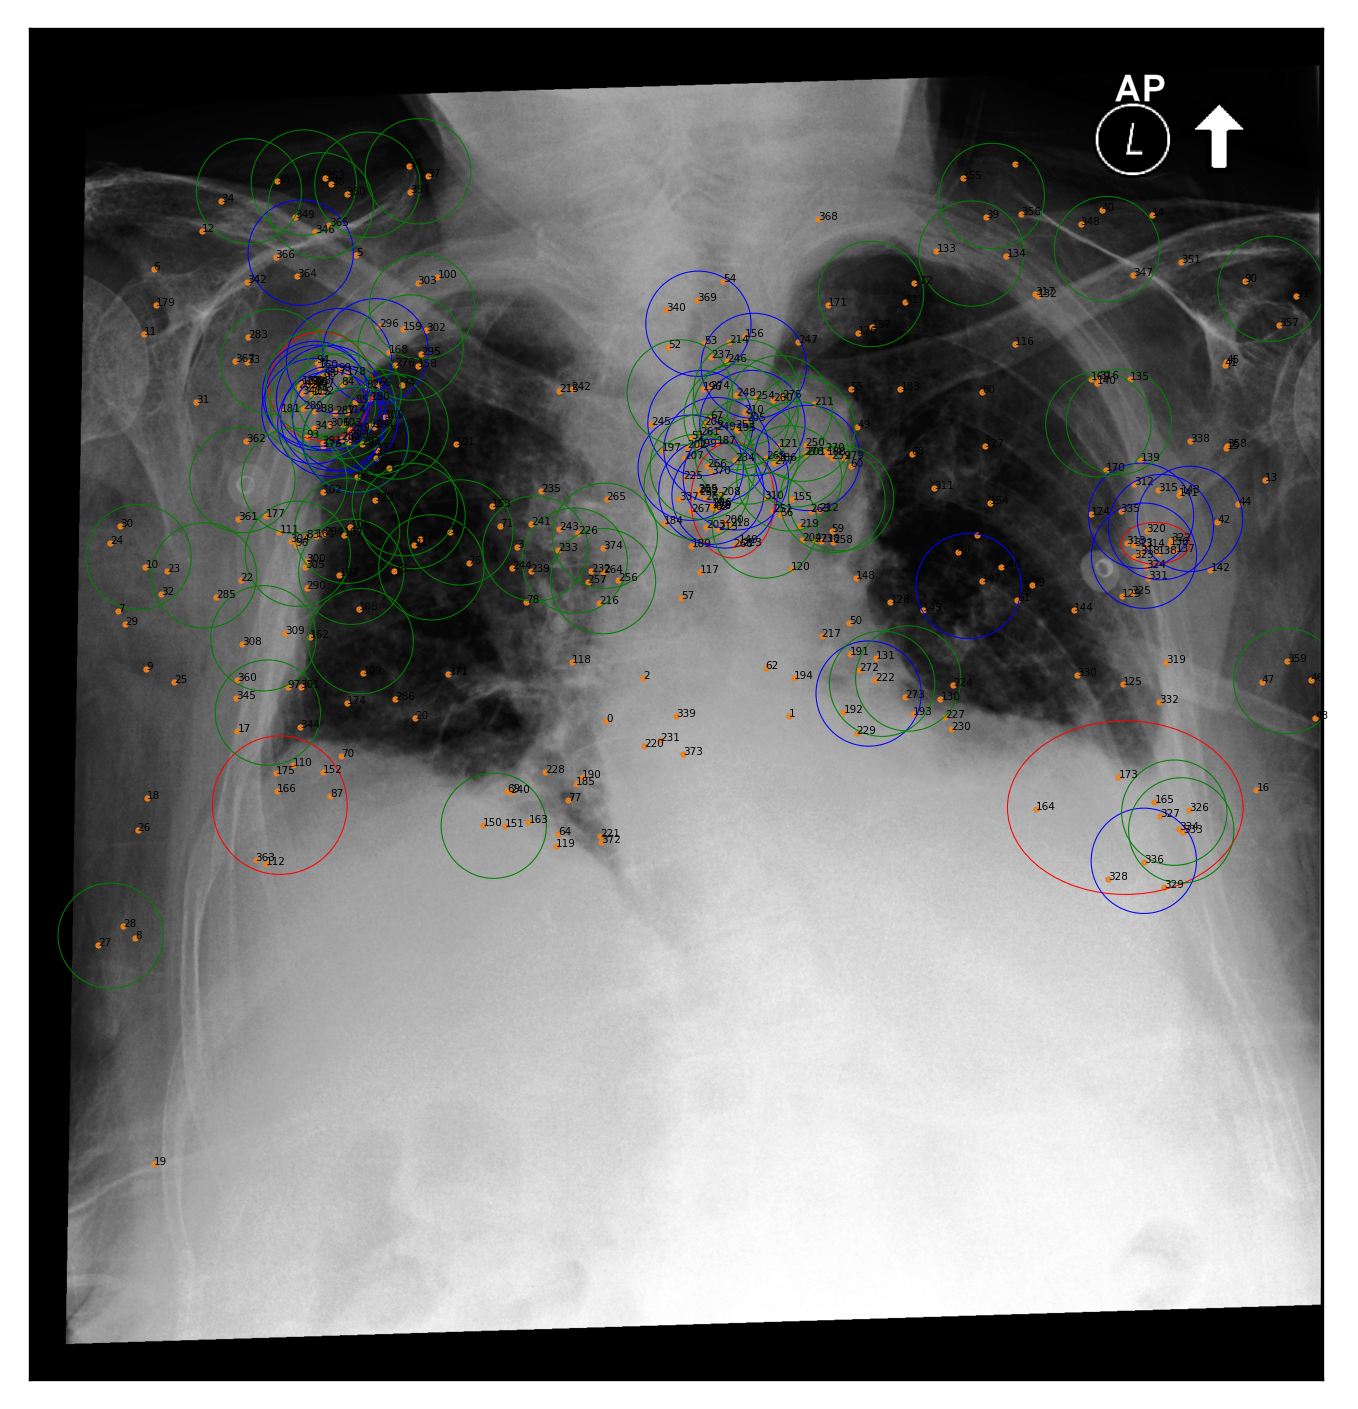

In [34]:
REFLACX = 1
IMAGE = 0
RADIUS = 94.96
#resetStats()
normal_graph = {}
ms_graph = {}
silence_graph = {}
certainty_graph = {}

for key, value in reflacx.items():
  if key not in ignore and key.startswith('patient'):
    image = f"{rootdir}/{key}/CXR-JPG/{value[IMAGE][0]}/{value[IMAGE][1]}"
    for reflacx_report in value[REFLACX]:
      if reflacx_report.startswith('P'):
        fixations = f"{rootdir}/{key}/REFLACX/{reflacx_report}/fixations.csv"
        elipses = f"{rootdir}/{key}/REFLACX/{reflacx_report}/anomaly_location_ellipses.csv"
        transcriptions = f"{rootdir}/{key}/REFLACX/{reflacx_report}/timestamps_transcription.csv"
        makePlot(key, value[IMAGE][0], reflacx_report, value[IMAGE][2], value[IMAGE][3], image, fixations, elipses, transcriptions)
        #computeStatistics(key, value[IMAGE][0], reflacx_report, value[IMAGE][2], value[IMAGE][3], image, fixations, elipses, transcriptions)
        #graphRelation(key, value[IMAGE][0], reflacx_report, value[IMAGE][2], value[IMAGE][3], image, fixations, elipses, transcriptions)
        #print(key)
        #print(normal_graph)
        #print(ms_graph)
        #print(silence_graph)
        #print(certainty_graph)
        break
    break


In [ ]:
REFLACX = 1
IMAGE = 0
radiuses = [90.5472, 94.96]
folders = ['radius_90', 'radius_94']

for step in zip(radiuses,folders):
  RADIUS = step[0]
  folder_name = step[1]
  resetStats()
  resetStatsMS()
  resetSilenceStats()
  for key, value in reflacx.items():
    if key not in ignore and key.startswith('patient'):
      image = f"{rootdir}/{key}/CXR-JPG/{value[IMAGE][0]}/{value[IMAGE][1]}"
      for reflacx_report in value[REFLACX]:
        if reflacx_report.startswith('P'):
          fixations = f"{rootdir}/{key}/REFLACX/{reflacx_report}/fixations.csv"
          elipses = f"{rootdir}/{key}/REFLACX/{reflacx_report}/anomaly_location_ellipses.csv"
          transcriptions = f"{rootdir}/{key}/REFLACX/{reflacx_report}/timestamps_transcription.csv"
          #makePlot(key, value[IMAGE][0], reflacx_report, value[IMAGE][2], value[IMAGE][3], image, fixations, elipses, transcriptions)
          #computeStatistics(key, value[IMAGE][0], reflacx_report, value[IMAGE][2], value[IMAGE][3], image, fixations, elipses, transcriptions)
          graphRelation(key, value[IMAGE][0], reflacx_report, value[IMAGE][2], value[IMAGE][3], image, fixations, elipses, transcriptions)
  break
  #printStats(step)
  #printStatsMS(step)
  #printSilenceStats(step)